# HMM GMM

We use 3-state mono-phone HMMs to construct this recognizer. The emission probability of every state is modeled by a GMM. Say we have F mono-phones (F = 39 in our English lexicon), and a G-mixture GMM for each mono-phone state. Thus the GMM-HMM has 3FG mixture components in total. Compared to GMM-UBM, these mixtures are better separated in the phoneme space.

MFCC:  MFCCs  are  extracted  from  16kHz  utterance  with  40 filter-banks distributed between 0 and 8kHz. Static 19-dimensional coefficients plus energy and their delta and delta-delta form a 60-dimensional vector. CMVN is applied per utterance.

Given a transcription, a graph of HMM is composed.

Speaker adaption is the same with Eq. 4 except mixtures here are phonetic dependent.

During the test phase,  the Viterbi-based log-likelihood ratio is expressed as:
sum_t log P(x_t | model_user,qt) - log P(x_t | model_ubm,qt)

HMM: To generate the alignment for the HMM-based modeling,we use MFCCs to train the HMM. 39 mono-phones plus a silencemodel are used,  each of which contains 3 states.  To model thecomplexity of silence, a GMM with 16 mixtures is used for every silence state, while other states are all modeled by 8 Gaussians,resulting 984 Gaussians in total. This HMM is further extended toa triphone system and remains 2142 senones.  The transcriptionsfor  DNN  training  is  generated  by  the  senone  alignment.   OnlyMFCCs are used for HMM training and alignment.

GMM-HMM and i-vector/HMM: The GMM of every state is re-estimated using the HMM alignments and different speaker fea-tures.   The total number of mixtures in our model is 984.   Thedimension of i-vector is again set to 600.  Viterbi and FB align-ments are both investigated

* 39 x 3 states

## Hmm, no dobra, plan działania:

Preprocessing:
wytnij ciszę z dźwięków, voice activity detection 
Wylicz MFCC, 20 stanów + d + dd 

Training:
Dla każdego sentence_id (jest ich 10):
    Utwórz HMMGMM z całego zbioru treningowego sequence_id:
        HMM with 3 states and 8 Gaussian components for each of 39 mono-phones were used for the alignment (resulting in to-tal number of 936 Gaussian components) ?? 
        albo unique(znaki) * 3 stany
        albo znaki * 3 stany trójkątna! (Bakis)
        
Enrollment:
Dla każdego gspeaker_id:
    Dla każdego sentence_id:
        Weź dane (gspeaker_id, sequence_id)
        Naucz HMM taki jak wyżej tylko na nich
        Dokonaj MAP adaptacji
        
Trial:
likelihood HMM_{podany speaker, podane zdanie} - likelihood HMM_{UBM, podane zdanie} ? 

In [1]:
%load_ext autoreload

In [33]:
%autoreload 2

import concurrent.futures as cf
import functools as ft
import itertools as it
import json
import math
import operator as op
import os
import re

from IPython.display import display
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import interpolate, linalg, misc, optimize, spatial, stats
from sklearn import metrics, mixture, cluster, utils

from paprotka.dataset import reddots
from paprotka.feature import cepstral

In [34]:
%autoreload 0

In [4]:
import warnings
warnings.filterwarnings('once')

# Load

In [5]:
root = reddots.get_root()
load_pcm = ft.partial(reddots.load_pcm, root)
load_mfcc = ft.partial(reddots.load_npy, root, 'wac2_mfcc13_ddd_lifter22_hamming')

In [6]:
all_paths = [os.path.join(os.path.basename(root), file) for root, _, files in os.walk(root + '/pcm') 
                                      for file in files 
                                      if file.endswith('.pcm')]
print(len(all_paths), all_paths[0])

15305 f0002/20150224142650384_f0002_14438.pcm


In [7]:
all_mfcc = {path: load_mfcc(path) for path in all_paths}

In [8]:
script = pd.read_csv(root + '/infos/phones.csv', sep=';')
print(script.loc[script['sentence_id'] == 31])

      sentence_id                  content  \
1609           31  My voice is my password   

                                                 phones  
1609  M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D  


In [9]:
def load_sets(eid, tid=None):
    tid = tid if tid else eid
    
    enrollments = reddots.load_enrollments(root + '/ndx/f_part_{}.trn'.format(eid), 
                                           root + '/ndx/m_part_{}.trn'.format(eid))
    trials = reddots.load_trials(root + '/ndx/f_part_{}.ndx'.format(tid), 
                                 root + '/ndx/m_part_{}.ndx'.format(tid))
    
    enrollments = enrollments.merge(script, how='left', on='sentence_id')
    trials = trials.merge(script, how='left', left_on='expected_sentence_id', right_on='sentence_id')
    del trials['sentence_id']
    trials.rename(columns={'content': 'expected_content', 'phones': 'expected_phones'}, inplace=True)
    trials = trials.merge(script, how='left', left_on='trial_sentence_id', right_on='sentence_id')
    del trials['sentence_id']
    trials.rename(columns={'content': 'trial_content', 'phones': 'trial_phones'}, inplace=True)
    
    return enrollments, trials

In [10]:
enrollments_1, trials_1 = load_sets('01')
print('Enrollments', enrollments_1.dtypes, sep='\n')
print('Trials', trials_1.dtypes, sep='\n')

Enrollments
is_male                  bool
pcm_path               object
sentence_id             int16
speaker_id              int16
timestamp      datetime64[ns]
content                object
phones                 object
dtype: object
Trials
correct_sentence                  bool
expected_is_male                  bool
expected_sentence_id             int16
expected_speaker_id              int16
pcm_path                        object
target_person                     bool
trial_is_male                     bool
trial_sentence_id                int16
trial_speaker_id                 int16
trial_timestamp         datetime64[ns]
expected_content                object
expected_phones                 object
trial_content                   object
trial_phones                    object
dtype: object


In [11]:
enrollments_2, trials_2 = load_sets('02')
enrollments_3, trials_3 = load_sets('03')
enrollments_4_td, trials_4_td = load_sets('04_td', '04')

In [12]:
trialed_paths = set(path for trials in (trials_1, trials_2, trials_3, trials_4_td) for path in trials.pcm_path)
untrialed_paths = [path for path in all_paths if path not in trialed_paths]
print(len(trialed_paths), len(untrialed_paths))

10857 4448


In [13]:
shit_lengths = np.array([mfcc.shape[0] for mfcc in all_mfcc.values()])
print(shit_lengths.min(), shit_lengths.mean(), shit_lengths.max(), shit_lengths)

shit_lengths_sorted = np.sort(shit_lengths)

print(shit_lengths_sorted[:40])
print(shit_lengths_sorted[-40:])

1 316.151323097 1219 [289 398 300 ..., 261 193 370]
[ 1  1  1  7  8  9  9  9 11 12 12 12 12 13 23 27 60 60 78 79 80 85 86 87 87
 87 89 89 89 89 89 89 89 89 91 91 92 92 93 93]
[1047 1047 1057 1058 1059 1059 1063 1065 1065 1067 1067 1067 1069 1069 1071
 1076 1078 1078 1078 1082 1086 1088 1088 1090 1181 1181 1181 1181 1181 1181
 1185 1185 1200 1200 1202 1202 1219 1219 1219 1219]


In [14]:
trialed_paths = [path for path in trialed_paths if all_mfcc[path].shape[0] >= 85]
untrialed_paths = [path for path in untrialed_paths if all_mfcc[path].shape[0] >= 85]

In [15]:
# memory blew up
# enrollments_1.mfcc = enrollments_1.apply(lambda row: load_mfcc(row.pcm_path), axis=1)
# trials_1.mfcc = trials_1.apply(lambda row: load_mfcc(row.pcm_path), axis=1)
# enrollments_4_td.mfcc = enrollments_4_td.apply(lambda row: load_mfcc(row.pcm_path), axis=1)

In [19]:
# got_this_back = pg.GeneralMixtureModel(bg_model.distributions, np.exp(bg_model.weights) * bg_model.weights.sum())
# got_this_back = pg.MultivariateGaussianDistribution(means=bg_model.distributions[0].mu, covariance=bg_model.distributions[0].cov)

def with_opened_file(mode='r'):
    def decorator(fun):
        @ft.wraps(fun)
        def wrapped(path, *args, **kwargs):
            with open(path, mode=mode) as opened:
                return fun(opened, *args, **kwargs)
        return wrapped
    return decorator

def write_model(path, model):
    with open(path, 'wb') as opened:
        pickle.dump(model, opened)
        
def read_model(path):
    with open(path, 'rb') as opened:
        return pickle.load(opened)
    
def write_triples(path, triples):
    for phone, triple in triples.items():
        for i, model in enumerate(triple):
            c = chr(ord('a') + i)
            write_model(path + '/{}-{}'.format(phone, c), model)
            
def read_triples(path, phones):
    triples = {}
    for phone in phones:
        triple = tuple(read_model(path + '/{}-{}'.format(phone, c)) 
                       for c in ('a', 'b', 'c'))
    return triples

# Train

In [20]:
example = enrollments_1[enrollments_1.sentence_id == 31]
example_features = [all_mfcc[path] for path in example['pcm_path']]
example_lengths = [mfcc.shape[0] for mfcc in example_features] 
example_features_stack = np.vstack(example_features)

print(len(example_features), example_features_stack.shape)

114 (37993, 39)


In [32]:
example

,is_male,pcm_path,sentence_id,speaker_id,timestamp,content,phones
0,False,f0002/20150216173043137_f0002_31.pcm,31,2,2015-02-16 17:30:43.137000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
1,False,f0002/20150216173047224_f0002_31.pcm,31,2,2015-02-16 17:30:47.224000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
2,False,f0002/20150216173052544_f0002_31.pcm,31,2,2015-02-16 17:30:52.544000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
30,False,f0004/20150303030806097_f0004_31.pcm,31,4,2015-03-03 03:08:06.097000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
31,False,f0004/20150303030810511_f0004_31.pcm,31,4,2015-03-03 03:08:10.511000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
32,False,f0004/20150303030815550_f0004_31.pcm,31,4,2015-03-03 03:08:15.550000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
60,False,f0005/20150329211618801_f0005_31.pcm,31,5,2015-03-29 21:16:18.801000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
61,False,f0005/20150329211619628_f0005_31.pcm,31,5,2015-03-29 21:16:19.628000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
62,False,f0005/20150329211620392_f0005_31.pcm,31,5,2015-03-29 21:16:20.392000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D
90,False,f0006/20150324145723981_f0006_31.pcm,31,6,2015-03-24 14:57:23.981000,My voice is my password,M AY1 _ V OY1 S _ IH1 Z _ M AY1 _ P AE1 S W ER2 D


In [21]:
untrialed_features = [all_mfcc[path] for path in untrialed_paths]
untrialed_features_stack = np.vstack(untrialed_features)

print(len(untrialed_features), untrialed_features_stack.shape)

4445 (1442782, 39)


## Make 8 and 16 mixtures all sentence models

In [22]:
# bg_model = mixture.GaussianMixture(
#     n_components=8, max_iter=10000, covariance_type='diag', 
#     random_state=13, verbose=1
# )
# bg_model.fit(untrialed_features_stack)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [23]:
# silence_model = mixture.GaussianMixture(
#     n_components=16, max_iter=10000, covariance_type='diag', 
#     random_state=13, verbose=1
# )
# silence_model.fit(untrialed_features_stack)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=16, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [24]:
# write_model(root + '/models/hmm/bg_model.pickle', bg_model)
# write_model(root + '/models/hmm/silence_model.pickle', silence_model)

In [21]:
bg_model = read_model(root + '/models/hmm/bg_model.pickle')
silence_model = read_model(root + '/models/hmm/silence_model.pickle')

## Clean sentences, build triples

In [43]:
recording_regex = re.compile(r'([mf])(\d+)/(\d+)_[mf]\d+_(\d+)')
def parse_recording(value):
    match = recording_regex.match(value)
    if match:
        return match.groups()

unique_sentence_ids = np.sort(np.unique([int(parse_recording(path)[3]) for path in untrialed_paths]))
unique_sentence_ids_scripted = [sentence_id for sentence_id in unique_sentence_ids
                                if (script.sentence_id == sentence_id).any()
                                if isinstance(script[script.sentence_id == sentence_id].phones.iloc[0], str)]
print(len(unique_sentence_ids), len(unique_sentence_ids_scripted))

811 769


In [189]:
sentence_id_mfcc_sequences = {
    sentence_id: [all_mfcc[path] for path in untrialed_paths 
                                 if int(parse_recording(path)[3]) == sentence_id
                                 if all_mfcc[path].shape[0] >= len(script[script.sentence_id == sentence_id].phones.iloc[0].split(' ') * 3)]
    for sentence_id in unique_sentence_ids_scripted
}

In [30]:
def wrap_with_silence(phones):
    return ['_'] + phones + ['_']

def remove_stress_combinations(phones):
    def remove_single_phone(phone):
        if phone[-1].isdigit():
            return phone[:-1]
        else:
            return phone
        
    return [remove_single_phone(phone) for phone in phones]

clean_phones = lambda phones: wrap_with_silence(remove_stress_combinations(phones))

In [26]:
UNIQUE_PHONES = [
    'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 
    'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 
    'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 
    'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z', 'ZH'
]

In [29]:
def load_ubm_copy():
    return read_model(root + '/models/hmm/bg_model.pickle')

def make_phone_triple():
    return tuple(load_ubm_copy() for _ in range(3))

phone_triples = {
    phone: make_phone_triple() for phone in UNIQUE_PHONES
}

In [187]:
def phone_to_states(phone_triples, silence_model, phone):
    if phone == '_':
        return (silence_model,)
    else:
        return phone_triples[phone]
    
def phones_to_states(phone_triples, silence_model, phones):
    return [state
            for phone in phones
            for state in phone_to_states(phone_triples, silence_model, phone)]

sentence_id_phones = {
    sentence_id: clean_phones(
        script[script.sentence_id == sentence_id].phones.iloc[0].split(' ')
    ) for sentence_id in unique_sentence_ids_scripted
}

sentence_id_state_sequences = {
    sentence_id: phones_to_states(phone_triples, silence_model, clean_phones(
        script[script.sentence_id == sentence_id].phones.iloc[0].split(' ')
    )) for sentence_id in unique_sentence_ids_scripted
}

In [213]:
def pick_stay_cdf(width):
    shift = stats.weibull_min.median(2, scale=width)
    return lambda x: 1 - stats.weibull_min.cdf(x, 2, scale=width, loc=width-shift)

def align_frames(state_gmms, features):
    hidden_n = len(state_gmms)
    frame_n, visible_n = features.shape
    
    frame_mean_width = max(1, np.floor(frame_n / hidden_n) - 1)
#     print(frame_mean_width)
#     stay_proba = pick_stay_cdf(frame_mean_width)(np.arange(frame_n))
    stay_counts = np.zeros(hidden_n, dtype=np.int32)
    
    joint_proba = np.zeros(hidden_n, dtype=np.float64)
    max_proba_ix = np.zeros((frame_n - 1, hidden_n), dtype=np.bool8)
    
    initial_hidden = np.zeros(hidden_n, dtype=np.float64)
    initial_hidden[0] = 1.0
    
    emission_probas = np.zeros((frame_n, hidden_n), dtype=np.float64)
    for i, state_gmm in enumerate(state_gmms):
        emission_probas[i:, i] = np.exp(state_gmm.score_samples(features[i:]))
#     emission_probas -= emission_probas.min()
#     emission_probas /= emission_probas.max()
#     emission_probas = np.exp(emission_probas)
    
    next_state_proba = np.zeros((2, hidden_n), dtype=np.float64)
    
#     print(stay_proba)
    for i, emission_proba in enumerate(emission_probas):
        if i == 0:
            joint_proba = initial_hidden * emission_proba
            stay_counts[0] = 1
        else:
            current_stay_proba = 1 / (1 + np.power(1.64128836, stay_counts - frame_mean_width))
            next_state_proba[0, :] = joint_proba * current_stay_proba
            next_state_proba[1, 1:] = joint_proba[:-1] * (1 - current_stay_proba[:-1])
            
            next_state_proba *= emission_proba
            
            joint_proba = next_state_proba.max(axis=0)
            max_proba_ix[i - 1] = next_state_proba.argmax(axis=0)
            
            ones_at_stays = ~max_proba_ix[i - 1]
            stay_counts = (stay_counts + 1) * ones_at_stays
#             print(*current_stay_proba)
#         print(stay_counts)
            
        joint_proba /= joint_proba.sum()
#         print(*joint_proba)
    
    most_likely_path = np.zeros(frame_n, dtype=np.int32)
    most_likely_path[-1] = len(joint_proba) - 1 
    for i in range(frame_n - 1, 0, -1):
        is_from_prev = max_proba_ix[i - 1, most_likely_path[i]]
        most_likely_path[i - 1] = most_likely_path[i] - is_from_prev
    
    return most_likely_path #, joint_proba[-1]
    
align_frames(sentence_id_state_sequences[31],
             all_mfcc['m0002/20150713085938321_m0002_31.pcm'])

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
       10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16,
       16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21,
       21, 21, 22, 22, 22, 23, 23, 23, 23, 24, 24, 25, 25, 25, 26, 26, 26,
       27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31,
       32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37,
       37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43,
       43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48,
       49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], dtype=int32)

In [228]:
align_frames(sentence_id_state_sequences[31],
             all_mfcc['m0002/20150713085938321_m0002_31.pcm'])

array([ 0,  1,  2,  3,  4,  5,  6,  6,  6,  7,  8,  8,  9, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14,
       14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 25, 26, 27, 28,
       28, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 31, 32, 33, 34, 34, 34,
       34, 34, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 38, 38, 38, 38, 39,
       39, 39, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 42, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 45,
       45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48,
       48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50], dtype=int32)

In [208]:
def phone_to_gmm_ids(phone):
    if phone == '_':
        return [('_', 0)]
    else:
        return [(phone, 0), (phone, 1), (phone, 2)]

def phones_to_gmm_ids(phones):
    return [gmm_id for phone in phones 
                   for gmm_id in phone_to_gmm_ids(phone)]

sentence_id_gmm_ids = {
    sentence_id: phones_to_gmm_ids(clean_phones(
        script[script.sentence_id == sentence_id].phones.iloc[0].split(' ')
    )) for sentence_id in unique_sentence_ids_scripted
}

In [211]:
def gather_state_frames(unique_sentence_ids_scripted, sentence_id_state_sequences, 
                        sentence_id_mfcc_sequences, sentence_id_gmm_ids):        
    gmm_id_frames = {}
    
    for sentence_id in unique_sentence_ids_scripted:
        print(sentence_id, end=' ')
        gmm_ids = sentence_id_gmm_ids[sentence_id]
        state_sequence = sentence_id_state_sequences[sentence_id]
        mfcc_sequences = sentence_id_mfcc_sequences[sentence_id]

        for mfcc_sequence in mfcc_sequences:
            alignment = align_frames(state_sequence, mfcc_sequence)
            
            for i, gmm_id in enumerate(gmm_ids):
                gmm_sequence = mfcc_sequence[alignment == i]
                
                if gmm_id not in gmm_id_frames:
                    gmm_id_frames[gmm_id] = []
                gmm_id_frames[gmm_id].append(gmm_sequence)
                
    return gmm_id_frames

In [215]:
def fit_gmm_frames(phone_triples, gmm_id_frames):
    for gmm_id, frames in gmm_id_frames.items():
        print(gmm_id, end=' ')
        phone, ix = gmm_id
        if phone == '_':
            continue
        gmm = phone_triples[phone][ix]
        frame_stack = np.vstack(frames)
        gmm.fit(frame_stack)

In [214]:
gmm_id_frames = gather_state_frames(unique_sentence_ids_scripted, sentence_id_state_sequences, 
                                    sentence_id_mfcc_sequences, sentence_id_gmm_ids)

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

In [223]:
fit_gmm_frames(phone_triples, gmm_id_frames)

('L', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('AY', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True
('DH', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('B', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('EY', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('IY', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('G', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
('AH', 0) Initialization 0
  Iteration 0
  Iterat

  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('P', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('AA', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('OY', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('AH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('F', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('S', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('M', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
('OW', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iterat

In [ ]:
for i in range(20):
    gmm_id_frames = gather_state_frames(unique_sentence_ids_scripted, sentence_id_state_sequences, 
                                        sentence_id_mfcc_sequences, sentence_id_gmm_ids)
    fit_gmm_frames(phone_triples, gmm_id_frames)

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('P', 0) Initialization 0
  Iteration 0
Initialization converged: True
('B', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('K', 0) Initialization 0
  I

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
 

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 10
Initialization converged: True
('B', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('AE', 2) Ini

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('P', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('B', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initi

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('DH', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Ini

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('DH', 0) Initialization 0
  Iteration 0
  Iteration 10
  I

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 10
  Iteration 20
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization co

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('DH', 0) Initialization 0
  

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('DH', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: Tr

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  I

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 10
  Iteration 20
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('DH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('CH', 1) Initialization 0
  Iteration 0
  

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  I

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('DH', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
('CH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: Tru

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 10
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('DH', 0) Initialization 0
  Iteration 0
Initialization co

31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 61 62 63 64 65 66 67 68 69 70 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 144 146 148 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 321 322 323 324 325 326 327 328 329 330 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 371 372 373 374 375 376 377 378 379 380 391 392 393 394 395 396 397 398 399 400 4

  Iteration 0
  Iteration 10
Initialization converged: True
('EY', 1) Initialization 0
  Iteration 0
Initialization converged: True
('EH', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('TH', 1) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
('HH', 1) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('W', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('R', 2) Initialization 0
  Iteration 0
Initialization converged: True
('OW', 2) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('ER', 0) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('K', 0) Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
('AE', 2) Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
('T', 2) Init

# Enroll

In [ ]:
write_model(root + '/models/hmm/phone_triples_1.pickle', phone_triples)

In [ ]:
def load_phone_gmms_copy():
    return read_model(root + '/models/hmm/phone_triples_1.pickle')

def map_adapt(gmm, features, relevance_factor=3.0):
    proba = gmm.predict_proba(features)
    zero_stats = proba.sum(axis=0)
    first_stats = proba.T @ features
    new_means = first_stats / zero_stats[:, np.newaxis]
    new_means[~np.isfinite(new_means)] = gmm.means_[~np.isfinite(new_means)]
    replace_factor = zero_stats / (zero_stats + relevance_factor)
    adapted_means = gmm.means_ + replace_factor[:, np.newaxis] * (new_means - gmm.means_)
    gmm.means_ = adapted_means

In [ ]:
def split_enrollments(enrollments):
    unique_males = enrollments[enrollments.is_male].speaker_id.unique()
    unique_females = enrollments[~enrollments.is_male].speaker_id.unique()
    unique_sentences = enrollments.sentence_id.unique()
    return unique_males, unique_females, unique_sentences

def map_adapt_triples(speaker_triple_gmms, gmm_id_frames):
    for gmm_id, frames in gmm_id_frames.items():
        phone, ix = gmm_id
        if phone == '_':
            continue
        gmm = speaker_triple_gmms[phone][ix]
        frame_stack = np.vstack(frames)
        map_adapt(gmm, frame_stack)

def enroll_speakers(all_mfcc, enrollments):
    males, females, _ = split_enrollments(enrollments)
    
    speaker_class_gmms = {}
    for is_male, speaker_ids in ((True, males), (False, females)):
        for speaker_id in speaker_ids:
            speaker_gmms = load_phone_gmms_copy()
            
            speaker_mask = (enrollments.is_male == is_male) & (enrollments.speaker_id == speaker_id)
            speaker_groups = enrollments[speaker_mask][['sentence_id', 'pcm_path']].groupby('sentence_id')
            
            speaker_unique_sentence_ids_scripted = speaker_groups.groups.keys()
            speaker_sentence_id_mfcc_sequences = {
                sentence_id: [all_mfcc[path] for path in speaker_groups.get_group(sentence_id).pcm_path]
                for sentence_id in speaker_unique_sentence_ids_scripted
            }
            
            speaker_stacks = gather_state_frames(speaker_unique_sentence_ids_scripted, sentence_id_state_sequences, 
                                                 speaker_sentence_id_mfcc_sequences, sentence_id_gmm_ids)
            map_adapt_triples(speaker_gmms, speaker_stacks)
            
            speaker_class_gmms[(is_male, speaker_id)] = speaker_gmms
            
    return speaker_class_gmms

In [ ]:
enrollments_1_speaker_class_gmms = enroll_speakers(all_mfcc, enrollments_1)

# Test

In [ ]:
def score_triple_gmm(scored_phone_triples, align_state_sequence, 
                     all_mfcc, sentence_id_gmm_ids, alignment_cache, path, sentence_id):        
    mfcc_sequence = all_mfcc[path]
    
    key = (path, sentence_id)
    if key in alignment_cache:
        alignment = alignment_cache[key]
    else:
        alignment = align_frames(align_state_sequence, mfcc_sequence)
        alignment_cache[key] = alignment
    
    gmm_ids = sentence_id_gmm_ids[sentence_id]
    
    total_proba = 0
    for i, gmm_id in enumerate(gmm_ids):
        phone, ix = gmm_id
        if phone == '_':
            continue
            
        gmm_id_sequence = mfcc_sequence[alignment == i]
#         print(mfcc_sequence.shape, alignment.shape, gmm_id_sequence.shape)
        scored_gmm = scored_phone_triples[phone][ix]
        total_proba += scored_gmm.score(gmm_id_sequence)
        
    return total_proba

In [ ]:
def perform_trials(alignment_cache, speaker_phone_triples, phone_triples,
                   all_mfcc, sentence_id_gmm_ids, sentence_ids_phones,
                   sentence_id_state_sequences, trials):
    size = len(trials)
    size_100 = size // 100
    
    scores = np.zeros((size, 3), dtype=np.float64)
    flags = np.zeros((size, 6), dtype=np.bool)
    
    for i, trial in trials.iterrows():
        sentence_id = trial.expected_sentence_id
        pcm_path = trial.pcm_path
        
        if all_mfcc[pcm_path].shape[0] < min(85, len(sentence_id_state_sequences[sentence_id])):
            flags[i, 5] = True
            continue
        
        ubm_score = score_triple_gmm(phone_triples, sentence_id_state_sequences[sentence_id], 
                                     all_mfcc, sentence_id_gmm_ids, alignment_cache, pcm_path, sentence_id)
        
        speaker_triples = speaker_phone_triples[(trial.expected_is_male, trial.expected_speaker_id)]
        speaker_score = score_triple_gmm(speaker_triples, sentence_id_state_sequences[sentence_id], 
                                         all_mfcc, sentence_id_gmm_ids, alignment_cache, pcm_path, sentence_id)
        
        expected_is_male = trial.expected_is_male
        trial_is_male = trial.trial_is_male
        gender_right = trial.expected_is_male == trial.trial_is_male
        target_right = gender_right and (trial.expected_speaker_id == trial.trial_speaker_id)
        sentence_right = trial.expected_sentence_id == trial.trial_sentence_id
        
        sentence_score = 0
        scores[i, :] = (speaker_score, sentence_score, ubm_score)
        flags[i, :] = (expected_is_male, trial_is_male, gender_right, target_right, sentence_right, False)
        
        if i % size_100 == size_100 - 1:
            print(i, end=' ')
        
    return pd.DataFrame.from_dict({
        'speaker_score': scores[:, 0], 'sentence_score': scores[:, 1], 'ubm_score': scores[:, 2],
        'expected_is_male': flags[:, 0], 'trial_is_male': flags[:, 1], 'gender_right': flags[:, 2],
        'target_right': flags[:, 3], 'sentence_right': flags[:, 4], 'too_short': flags[:, 5]
    })

In [ ]:
alignment_cache = {}

In [ ]:
trials_1_results = perform_trials(alignment_cache, enrollments_1_speaker_class_gmms, phone_triples,
                                  all_mfcc, sentence_id_gmm_ids, sentence_id_phones,
                                  sentence_id_state_sequences, trials_1.head(10000))

# Visualize

In [ ]:
def equal_error_rate(fpr, tpr, thresholds):
    eer = optimize.brentq(lambda x : 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
    threshold = interpolate.interp1d(fpr, thresholds)(eer)
    return eer, threshold

def plot_roc(fpr, tpr, auc, eer, title):
    plt.figure(figsize=(8, 6))
    print(auc, eer)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.2%}, EER = {:.2%})'.format(auc, eer))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
def visualize_roc(fpr, tpr, thresholds, title=None):
    roc_auc = metrics.auc(fpr, tpr)
    eer, threshold = equal_error_rate(fpr, tpr, thresholds)
    plot_roc(fpr, tpr, roc_auc, eer, title=title)
    
def visualize_results(results):
    # is target right, disregarding sentence
    roc_target_right = metrics.roc_curve(results.target_right, results.speaker_prob)
    visualize_roc(*roc_target_right, title='ROC - speaker correct problem')

    # is sentence correct or wrong, disregarding target
    roc_sentence_right = metrics.roc_curve(results.sentence_right, results.sentence_prob)
    visualize_roc(*roc_sentence_right, title='ROC - sentence correct problem')

    # is target right, when the sentence is correct
    roc_both_right = metrics.roc_curve(results.target_right & results.sentence_right, results.both_prob)
    visualize_roc(*roc_both_right, title='ROC - speaker and sentence correct problem')

In [ ]:
trials_1_results['speaker_prob'] = np.exp(trials_1_results.speaker_score - np.maximum(trials_1_results.ubm_score, trials_1_results.speaker_score))
# trials_1_results['sentence_prob'] = np.exp(trials_1_results.sentence_score - np.maximum(trials_1_results.ubm_score, trials_1_results.sentence_score))
# trials_1_results['both_prob'] = np.exp(trials_1_results.speaker_score - np.maximum(trials_1_results.ubm_score, trials_1_results.speaker_score)
#                                      + trials_1_results.sentence_score - np.maximum(trials_1_results.ubm_score, trials_1_results.sentence_score))
trials_1_results['sentence_prob'] = trials_1_results.sentence_score
trials_1_results['both_prob'] = np.exp(trials_1_results.speaker_score - np.maximum(trials_1_results.ubm_score, trials_1_results.speaker_score)) \
                              * trials_1_results.sentence_score

In [ ]:
visualize_results(trials_1_results[~trials_1_results.too_short])

0.95235771062 0.11267605633802807


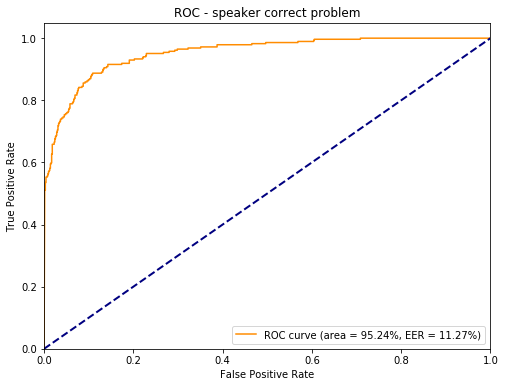

0.5 0.5


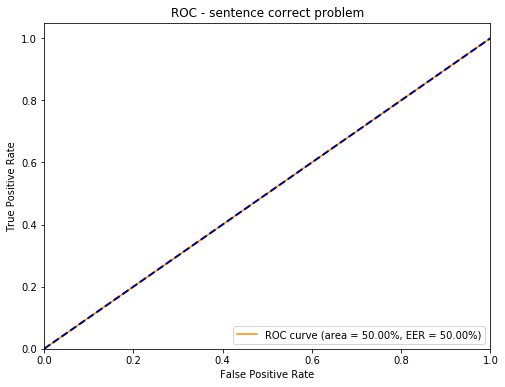

0.5 0.5


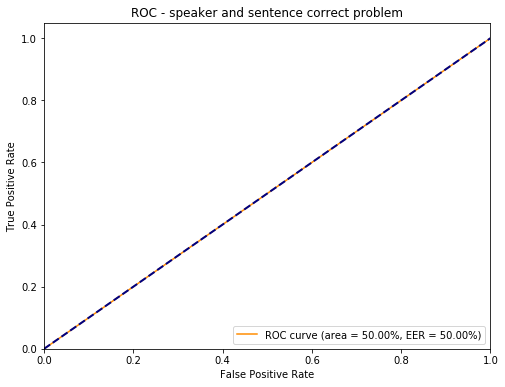

In [326]:
visualize_results(trials_1_results[~trials_1_results.too_short])

# Linia śmieci

In [27]:
def make_sentence_hmm(phones_cell, phone_triples, silence_model):
    phones = phones_cell.split(' ')
    cleaned_phones = clean_phones(phones)
    hmm = pg.HiddenMarkovModel('-'.join(cleaned_phones))
    
    states = []
    for i, phone in enumerate(cleaned_phones):
        if phone == '_':
            phone_state = pg.State(silence_model.copy(), name='{}-SILENCE'.format(i))
            states.append(phone_state)
        else:
            phone_triple = phone_triples[phone]
            phone_states = (
                pg.State(phone_triple[0], name='{:02}a-{}'.format(i, phone)),
                pg.State(phone_triple[1], name='{:02}b-{}'.format(i, phone)),
                pg.State(phone_triple[2], name='{:02}c-{}'.format(i, phone))
            )
            states.extend(phone_states)
    hmm.add_states(states)
    
    hmm.add_transition(hmm.start, states[0], 1.0)
    for state in states:
        hmm.add_transition(state, state, 0.9)
    for prev, then in zip(states, states[1:]):
        hmm.add_transition(prev, then, 0.1)
    hmm.add_transition(states[-1], hmm.end, 0.1)
    hmm.bake()
    
    return hmm

# make_sentence_hmm(
#     script[script.sentence_id == 31].phones.iloc[0], 
#     phone_distribution_triples, silence_model
# );

In [30]:
sentence_hmms = {
    sentence_id: make_sentence_hmm(
        script[script.sentence_id == sentence_id].phones.iloc[0], phone_distribution_triples, silence_model
    ) for sentence_id in unique_sentence_ids_scripted
}

In [31]:
print(len(sentence_hmms))

769


## Train HMMs

In [33]:
def update_triples(phone_triples):
    empty = 0
    lost = 0
    for phone_triple in phone_triples.values():
        for gmm in phone_triple:
            if gmm.summaries.sum() == 0:
                empty += 1
                continue
            try:
                gmm.from_summaries()
            except Exception:
                gmm.clear_summaries()
                lost += 1
    return empty, lost

def train_epoch(sentence_sequencess, unique_sentence_ids, sentence_hmms, phone_triples):
    logps = []
    
    for sentence_id in unique_sentence_ids:
        print(sentence_id, end=' ')
        
        sentence_hmm = sentence_hmms[sentence_id]
        sentence_sequences = sentence_sequencess[sentence_id]
        weights = np.ones(len(sentence_sequences))
        
        logp = sentence_hmm.summarize(sequences=sentence_sequences, weights=weights, check_input=False)
                                      # algorithm='viterbi', 
        logps.append(logp)
    
    update_triples(phone_triples)
            
    return logps

In [34]:
write_triples(root + '/models/triples-init', phone_distribution_triples)

FileNotFoundError: [Errno 2] No such file or directory: '../input/reddots_r2015q4_v1/models/triples-init/AW-a'

In [ ]:
enrollments_4_td.phones[~enrollments_4_td.phones.isna()].apply(lambda row: len(row.split(' '))).describe()

In [ ]:
for i in range(10):
    for j in range(10):
        logps = train_epoch(sentence_sequencess, unique_sentence_ids_scripted, 
                            sentence_hmms, phone_distribution_triples)
        print('{}-{} logps'.format(i, j), sum(logps))
    path = root + '/models/triples-{}'.format(i)
    os.mkdir(path)
    write_triples(path, phone_distribution_triples)

In [160]:
update_triples(phone_distribution_triples)

(0, 0)

In [243]:
write_triples(root + '/models/triples', phone_distribution_triples)

In [21]:
phone_distribution_triples = read_triples(root + '/models/triples-1', UNIQUE_PHONES)

OSError: Cannot read model AW-a

In [105]:
print(example_sentence_hmm.states[3].distribution.distributions[0].mu)
print(example_sentence_hmm.states[10].distribution.distributions[0].mu)
print(example_sentence_hmm.states[10].name)

[  1.41467275e+01  -7.35344053e+00  -5.56301231e+00  -4.84370700e+00
  -3.26590152e+00  -4.67713110e+00  -2.93247692e+00  -6.21254481e+00
  -4.60166262e+00  -4.32767984e+00  -1.62883341e+00  -2.50476327e+00
  -8.24130769e+00   4.71618683e-01   4.57870227e-01  -1.32589895e+00
  -9.23610116e-01  -9.11397488e-01  -4.48633292e-02   6.83980317e-01
  -3.91819699e-01  -9.57840195e-02  -5.51740595e-01  -4.66018632e-01
  -3.27380013e-01   2.68423365e-03   6.40123001e-03   1.34323619e-01
   6.15838646e-03  -4.11852850e-02   7.89280213e-02  -2.26739330e-02
   5.75374672e-02   6.40953838e-03  -3.25918412e-02   1.42842274e-01
  -1.47236299e-01  -6.17011349e-02  -1.74521876e-02]
[  1.43344790e+01   1.12123728e-01  -4.61673784e+00  -4.37537285e+00
  -3.35688364e+00  -5.19159258e+00  -2.46247097e+00  -5.27950688e+00
  -6.93267329e+00   8.92074965e-01  -1.50063469e+00  -3.92398961e+00
  -1.10409868e+01   2.92374934e-01   1.52636161e+00  -1.38141933e+00
  -6.50400994e-01  -7.84072233e-01   1.30328483e-0

In [71]:
for i in (0, 50, 100):
    predictions = example_sentence_hmm.predict(example_features[i], algorithm='viterbi')
    print(i)
    print('\t'.join(example_sentence_hmm.states[prediction].name for prediction in predictions))

0
_-M-AY-_-V-OY-S-_-IH-Z-_-M-AY-_-P-AE-S-W-ER-D-_-start	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	0-SILENCE	1-M-beg	1-M-mid	1-M-end	2-AY-beg	2-AY-mid	2-AY-end	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-SILENCE	3-S

In [76]:
example_sentence_hmm.fit(example_features, algorithm='viterbi', n_jobs=12, verbose=True)

TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[1] Improvement: 4.373646683990955	Time (s): 522.3


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[2] Improvement: 3.142620590282604	Time (s): 525.5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[3] Improvement: 2.783811260247603	Time (s): 530.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[4] Improvement: 7.239276696462184	Time (s): 530.8


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[5] Improvement: 3.898073144024238	Time (s): 516.5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[6] Improvement: 0.22262321808375418	Time (s): 530.8


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[7] Improvement: 0.10438551963306963	Time (s): 532.6


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[8] Improvement: 0.14116176054812968	Time (s): 528.2


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[9] Improvement: 0.3834380640182644	Time (s): 537.4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[10] Improvement: 2261.235246648779	Time (s): 535.2


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[11] Improvement: 0.40921230893582106	Time (s): 537.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[12] Improvement: 0.3671781518496573	Time (s): 539.7


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[13] Improvement: 1.550668956944719	Time (s): 539.5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[14] Improvement: 6.940896178362891	Time (s): 536.8


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[15] Improvement: 23.50617057411	Time (s): 529.4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[16] Improvement: 16.49457749002613	Time (s): 542.3


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[17] Improvement: 4.811783917946741	Time (s): 534.2


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[18] Improvement: 8.078985502710566	Time (s): 534.7


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[19] Improvement: 104.82299938937649	Time (s): 529.4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[20] Improvement: 29.019449810730293	Time (s): 541.0


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[21] Improvement: 0.1271849311888218	Time (s): 531.6


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[22] Improvement: 0.23255512560717762	Time (s): 541.4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[23] Improvement: 0.8345558159053326	Time (s): 538.8


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[24] Improvement: 2.3695152981672436	Time (s): 539.2


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[25] Improvement: 3.544300872599706	Time (s): 534.3


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[26] Improvement: 1.4649938035290688	Time (s): 536.8


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[27] Improvement: 2.373902595601976	Time (s): 540.3


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[28] Improvement: 1.8202342817094177	Time (s): 538.5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[29] Improvement: 1.1508187069557607	Time (s): 531.2


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[30] Improvement: 0.14089310844428837	Time (s): 537.6


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[31] Improvement: 0.025304103270173073	Time (s): 539.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[32] Improvement: 0.009570289170369506	Time (s): 543.2


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[33] Improvement: 0.00407100236043334	Time (s): 543.1


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[34] Improvement: 0.0019249648321419954	Time (s): 541.6


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[35] Improvement: 0.0011146396864205599	Time (s): 539.0


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[36] Improvement: 0.0008710524998605251	Time (s): 525.0


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[37] Improvement: 0.0008764134254306555	Time (s): 538.1


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[38] Improvement: 0.0009993412531912327	Time (s): 540.0


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[39] Improvement: 0.001191070070490241	Time (s): 539.7


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[40] Improvement: 0.0014419096987694502	Time (s): 535.4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[41] Improvement: 0.0017632839735597372	Time (s): 540.5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[42] Improvement: 0.002181523945182562	Time (s): 541.7


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[43] Improvement: 0.0027372855693101883	Time (s): 541.3


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[44] Improvement: 0.003487061243504286	Time (s): 533.4


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[45] Improvement: 0.004502558847889304	Time (s): 538.3


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[46] Improvement: 0.005859382683411241	Time (s): 544.0


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[47] Improvement: 0.007597721880301833	Time (s): 538.6


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[48] Improvement: 0.009630846790969372	Time (s): 543.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[49] Improvement: 0.011602562153711915	Time (s): 532.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[50] Improvement: 0.01280992547981441	Time (s): 542.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[51] Improvement: 0.01246536965481937	Time (s): 535.5


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[52] Improvement: 0.010371301788836718	Time (s): 541.7


LinAlgError: 39-th leading minor not positive definite

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2261, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
  File "/usr/local/lib/python3.5/dist-packages/scipy/linalg/decomp_cholesky.py", line 81, in cholesky
    check_finite=check_finite)
  File "/usr/local/lib/python3.5/dist-packages/scipy/linalg/decomp_cholesky.py", line 30, in _cholesky
    raise LinAlgError("%d-th leading minor not positive definite" % info)
numpy.linalg.linalg.LinAlgError: 39-th leading minor not positive definite


[53] Improvement: 57.83760084374808	Time (s): 541.0


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[54] Improvement: 0.004460606258362532	Time (s): 541.7


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[55] Improvement: 0.0024528754875063896	Time (s): 541.1


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[56] Improvement: 0.00127413310110569	Time (s): 541.1


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[57] Improvement: 0.0006458016578108072	Time (s): 540.1


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[58] Improvement: 0.00032188952900469303	Time (s): 542.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[59] Improvement: 0.000154552748426795	Time (s): 543.1


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[60] Improvement: 6.717629730701447e-05	Time (s): 534.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[61] Improvement: 2.1627172827720642e-05	Time (s): 537.9


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 710, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions.pyx", line 2259, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


[62] Improvement: -1.4025717973709106e-06	Time (s): 544.4
Total Training Improvement: 2551.5645321204793
Total Training Time (s): 33826.2032


2551.5645321204793

## Enroll

In [54]:
def make_speaker_classifier(inspeaker_classifier):
    n_components = 3 * len(phones)
    initial, transitions = make_matrix_beads(n_components)

    classifier = hmm.GMMHMM(
        n_components=n_components, n_mix=8, covariance_type='diag', init_params='mcw', params='tmcw'
    )

    classifier.startprob_ = initial
    classifier.transmat_ = transitions

GMMHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
    init_params='stmcw', n_components=39, n_iter=10, n_mix=8,
    params='stmcw', random_state=None, startprob_prior=1.0, tol=0.01,
    transmat_prior=1.0, verbose=False)

In [ ]:
def perform_enrollments(classifier, enrollments):
    labels = enrollments[['is_male', 'speaker_id', 'sentence_id']].values
    features = [load_mfcc(path) for path in enrollments_1['pcm_path']]
    classifier.fit(features, labels)
    

## Trial

In [ ]:
def save_results(label, results):
    path = os.path.join(root, 'result', label)
    with open(path) as opened:
        pickle.dump(results, opened)
        
def load_results(label):
    path = os.path.join(root, 'result', label)
    with open(path) as opened:
        return pickle.load(opened)
    
def perform_trial(classifier, path):
    features = load_mfcc(path)
    return classifier.predict_single_proba(features)

def perform_trials(classifier, trials):
    paths = trials['pcm_path'].unique()
    results = {}
    for path in paths:
        results[path] = perform_trial(classifier, path)
    return results